In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import keras
import tensorflow as tf
import random

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import random
#import tqdm
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
#Importing drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Setting file paths in drive
path = '/content/drive/MyDrive/CourseWork/Deeplearning for Vision and NLP/litter_detection_model'

#raw images
raw_image_path = path + '/raw_images'
punalur_raw_image_path = raw_image_path + '/Punalur/'
falkirk_raw_image_path = raw_image_path + '/Falkirk'

#annotated images
annotated_image_path = path + '/annotated_images'
punalur_annotated_image_path = annotated_image_path + '/Punalur'
falkirk_annotated_image_path = annotated_image_path + '/Falkirk'


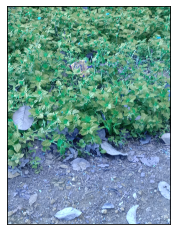

In [5]:
punalur_raw_images = [image for image in os.listdir(raw_image_path+'/Punalur/')]


first_image = cv2.imread(punalur_raw_image_path+punalur_raw_images[3], cv2.COLOR_BGR2RGB)

plt.imshow(first_image)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()


In [6]:
txt_files = [f for f in os.listdir(punalur_annotated_image_path) if f.lower().endswith('.txt')]
txt_files.remove('classes.txt')

# Reading the content of each .txt file

annotated_punalur_files = []
for txt_file in txt_files:
    # print(txt_file)
    file_path = os.path.join(punalur_annotated_image_path, txt_file)
    with open(file_path, 'r') as f:
        cols = ['label_class', 'x_center', 'y_center', 'width', 'height']
        content = pd.read_csv(f, sep=' ', names = cols)
    annotated_punalur_files.append({txt_file:content})

In [32]:

def get_train_images_labels(annotated_files_list):

  train_images = []
  train_labels = []

  for annotated_file in annotated_files_list:

    #Extracting file name to fetch the corresponding raw image
    file_name = list(annotated_file.keys())[0]

    for entry in annotated_file:

      #Iterating through each lines of the annotated file(ie, different object labels)
      df = annotated_file[entry]
      for index, row in df.iterrows():
        # print(row)
        class_label = row['label_class']
        x_center = row['x_center']
        y_center = row['y_center']
        height = row['height']
        width = row['width']

    # Reading the corresponding raw image
    image_path = os.path.join(punalur_raw_image_path, file_name.replace(".txt", ".jpg"))
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


    H, W, _ = img.shape
    x1 = int((x_center - width / 2) * W)
    y1 = int((y_center - height / 2) * H)
    x2 = int((x_center + width / 2) * W)
    y2 = int((y_center + height / 2) * H)

    cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 10)

    # Cropping the object and resizing to the standard size
    cropped_image = img[y1:y2, x1:x2]
    resized_image = cv2.resize(cropped_image, (224, 224))
    
    train_images.append(resized_image)
    train_labels.append(class_label)

  return train_images, train_labels
    


In [8]:
X_new, Y_new = get_train_images_labels(annotated_punalur_files)
X_new = np.array(X_new)
Y_new = np.array(Y_new)
X_new = preprocess_input(X_new)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.1, random_state=42)



In [29]:
num_classes = 1  #Class: Trash

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
# predictions = Dense(num_classes, activation='softmax')(x)
predictions = Dense(num_classes, activation='sigmoid')(x)

model = Model(inputs = base_model.input, outputs=predictions)

In [30]:
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 10 
batch_size = 10

history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_test, y_test))

Epoch 1/10
4/4 [==============================] - 6s 323ms/step - loss: 0.5153 - accuracy: 0.9211 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
4/4 [==============================] - 1s 181ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 1s 179ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 1s 181ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 1s 180ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 1s 181ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 1s 181ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.

In [34]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")


1/1 [==============================] - 0s 75ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test loss: 0.0, Test accuracy: 1.0
